In [101]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [102]:
#Reading in data
# ==============================================================================
building5=pd.read_csv('Building 5.csv')

In [103]:
#Converting to Datetime objects
# ==============================================================================
building5['datetime']=pd.to_datetime(building5['datetime'], format='%Y-%m-%d %H:%M:%S')
building5= building5.set_index('datetime')
building5= building5.asfreq('H')

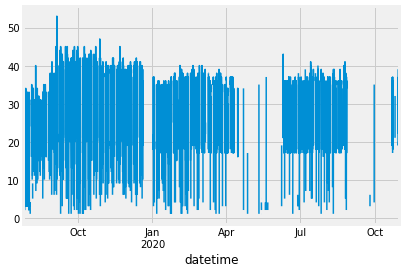

In [104]:
building5['series_value'].plot()

In [105]:
#Further Split Train-Val for Building
# ==============================================================================
end_train='2019-10-01 00:00'
start_val='2019-10-01 01:00'
end_val='2019-11-01 00:00'
start_test='2020-02-01 00:00'
end_test='2020-03-01 00:00'

building5train=building5.loc[:end_train, :]
building5val=building5.loc[start_val:end_val, :]
building5test=building5.loc[start_test:end_test,]

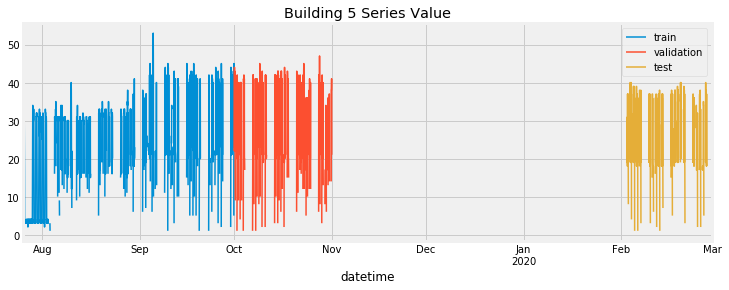

In [108]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
building5train['series_value'].plot(ax=ax, label='train')
building5val['series_value'].plot(ax=ax, label='validation')
building5test['series_value'].plot(ax=ax, label='test')
ax.set_title('Building 5 Series Value')
ax.legend();

In [107]:
building5=building5.dropna()

In [97]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-24 13:15:22 
Last fit date: None 
Skforecast version: 0.4.3 

In [126]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = building5.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building5train.dropna())),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran


----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in f

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran


----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in f

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 


    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in fold: 5
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-22 00:00:00 -- 2019-10-24 23:00:00
Data partition in fold: 6
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-25 00:00:00 -- 2019-10-29 23:00:00
Data partition in fold: 7
    Training:   2019-07-25 23:00:00 -- 2019-10-01 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran


----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in f

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in fold: 5
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-22 00:00:00 -- 2019-10-24 23:00:00
Data partition in fold: 6
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-25 00:00:00 -- 2019-10-29 23:00:00
Data partition in fold: 7
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-30 00:00:00 -- 2019-11-01 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data parti

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in fold: 5
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-22 00:00:00 -- 2019-10-24 23:00:00
Data partition in fold: 6
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-25 00:00:00 -- 2019-10-29 23:00:00
Data partition in fold: 7
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-30 00:00:00 -- 2019-11-01 00:00:00

Information of backtesting process

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran


----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in f

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran


----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in f

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 102.02728426132272



In [117]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = building5['series_value'],
    initial_train_size = len(building5.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 111.92241551515392


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

In [118]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",102.027284,0.01,10.0,500.0
29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",102.698719,0.01,10.0,500.0
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",102.905266,0.10,5.0,100.0
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",103.818602,0.10,3.0,100.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",104.305932,0.01,10.0,500.0
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",104.462670,0.10,5.0,500.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",106.186912,0.01,5.0,500.0
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",106.239405,0.01,5.0,500.0
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",106.508903,0.01,3.0,500.0
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",106.535863,0.01,5.0,500.0


In [119]:
# Predictions
# ==============================================================================
predictions

,pred
48,36.171962
49,29.627926
50,27.725580
51,31.700913
52,34.233338
...,...
49,26.856568
50,27.873049
51,22.392154
52,22.864346


In [122]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [123]:
building5test=building5test.dropna()
building5train=building5train.dropna()

In [128]:
LightGBM_MASE=mean_absolute_scaled_error(building5test.reset_index()['series_value'],predictions['pred'],building5train.reset_index()['series_value'])

In [129]:
# CatBoost Forecasting
# ==============================================================================

In [130]:
# Create Catboost forecaster
# ==============================================================================
cat_forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
                )

cat_forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x000002921A6A77B8> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-09-24 20:05:22 
Last fit date: None 
Skforecast version: 0.4.3 

In [131]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = cat_forecaster,
                        y                  = building5.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building5train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:   8%|███                                  | 1/12 [00:00<00:03,  3.16it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarni

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:05<00:05,  1.03s/it]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarni

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 97.89674049630216



In [132]:
# Backtesting
# ==============================================================================
metric, cat_predictions = backtesting_forecaster(
    forecaster = cat_forecaster,
    y          = building5['series_value'],
    initial_train_size = len(building5.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 106.68013606136945


In [133]:
CatBoost_MASE=mean_absolute_scaled_error(building5test.dropna().reset_index()['series_value'],cat_predictions['pred'],building5train.dropna().reset_index()['series_value'])

In [134]:
# Create XGB forecaster
# ==============================================================================
XGB_forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

XGB_forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 

In [135]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = XGB_forecaster,
                        y                  = building5.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building5train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:04<00:03,  1.64it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarni

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:04<00:03,  1.56it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarni

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:   8%|███                                  | 1/12 [00:00<00:03,  3.21it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarni

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  25%|█████████▎                           | 3/12 [00:01<00:03,  2.94it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarni

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:02<00:02,  2.35it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarni

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '

loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:03<00:01,  2.62it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 100.94806159346356



In [136]:
# Backtesting
# ==============================================================================
metric, XGB_predictions = backtesting_forecaster(
    forecaster = XGB_forecaster,
    y          = building5['series_value'],
    initial_train_size = len(building5.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 109.99643910372846


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '


In [137]:
XGB_MASE=mean_absolute_scaled_error(building5test.dropna().reset_index()['series_value'],XGB_predictions['pred'],building5train.dropna().reset_index()['series_value'])

In [138]:
#Using Prophet into LightGBM
# ==============================================================================
prophet=pd.read_csv('b5_actual_additive.csv')

In [139]:
#Converting to Datetime objects
# ==============================================================================
prophet['datetime']=pd.to_datetime(prophet['datetime'], format='%Y-%m-%d %H:%M:%S')
prophet= prophet.set_index('datetime')
prophet= prophet.asfreq('H')

In [143]:
prophettrain=prophet.loc[:end_train, :]
prophetval=prophet.loc[start_val:end_val, :]
prophettest=prophet.loc[start_test: end_test, :]

In [144]:
prophet=prophet.dropna()

In [145]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = prophet.loc[:end_val, 'subtraction'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(prophettrain)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran


----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in f

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

loop param_grid:  42%|███████████████▍                     | 5/12 [00:00<00:01,  5.98it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` ha

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 


----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in f

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran


----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in f

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 


----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-10-21 23:00:00
Data partition in f

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 700
Number of observations used for backtesting: 277
    Number of folds: 8
    Number of steps per fold: 36
    Last fold only includes 25 observations

Data partition in fold: 0
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 01:00:00 -- 2019-10-04 00:00:00
Data partition in fold: 1
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-04 01:00:00 -- 2019-10-08 23:00:00
Data partition in fold: 2
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 00:00:00 -- 2019-10-13 23:00:00
Data partition in fold: 3
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-14 00:00:00 -- 2019-10-16 23:00:00
Data partition in fold: 4
    Training:   2019-07-25 23:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-17 00:00:00 -- 2019-


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


In [146]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",104.836325,0.01,3.0,100.0
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",106.037029,0.01,3.0,100.0
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",106.469672,0.01,10.0,100.0
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",106.527746,0.01,5.0,100.0
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",106.541067,0.01,5.0,100.0
28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",106.939278,0.01,10.0,100.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",107.383841,0.01,10.0,100.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",108.212965,0.01,3.0,100.0
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",108.243576,0.01,3.0,500.0
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",108.252193,0.01,3.0,500.0


In [147]:
# Backtesting
# ==============================================================================
metric, prophet_predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = prophet['subtraction'],
    initial_train_size = len(prophet.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Backtest error: 103.59939656456915


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

In [148]:
# Predictions
# ==============================================================================
prophet_predictions

,pred
48,12.158870
49,14.389420
50,12.313132
51,12.030753
52,13.954348
...,...
49,14.039249
50,12.747490
51,14.124405
52,13.402974


In [149]:
prophet_predictions_final=prophet_predictions.reset_index()['pred']+prophet.loc[start_test:, :].reset_index()['additive_terms']

In [150]:
prophettest=prophettest.dropna()
prophettrain=prophettrain.dropna()

In [151]:
LightGBM_Prophet_MASE=mean_absolute_scaled_error(prophettest.reset_index()['subtraction'],prophet_predictions_final,prophettrain.reset_index()['subtraction'])

In [152]:
LightGBM_Prophet_MASE

2.0697727694415824

In [153]:
LightGBM_MASE

1.4240162193682862

In [154]:
CatBoost_MASE

1.383890696034728

In [155]:
XGB_MASE

1.3784798131815141